In [260]:
# Functions
## Initialize the environment
def initialize_game():
    if np.random.rand() < 0.99:
        # 99% chance to return 42
        return 42
    else:
        # 1% chance to return a number between 1 and 100, excluding 42
        num = np.random.randint(1, 100)
        if num >= 42:
            num += 1
        return num

## Define the feedback mechanism
def get_feedback(guess, target_number):
    if guess < target_number:
        return 'higher'
    elif guess > target_number:
        return 'lower'
    else:
        return 'correct'
    
## Q-learning update rule
def update_q_table(q_table, state, action, reward, next_state, alpha, gamma):
    # Adjust the state and action to be zero-indexed
    state_index = state[0] - 1
    next_state_index = next_state[0] - 1
    next_state_max_index = next_state[1] - 1

    # Ensure action is within bounds
    action = max(0, min(action, q_table.shape[1] - 1))

    # Get the current Q value for the state-action pair
    current_q = q_table[state_index, action]

    # Get the max future Q value for the next state, ensuring the slice is within bounds
    max_future_q = np.max(q_table[next_state_index:next_state_max_index+1]) if next_state_max_index >= next_state_index else 0

    # Update the Q value for the state-action pair
    q_table[state_index, action] = (1 - alpha) * current_q + alpha * (reward + gamma * max_future_q)

## Reward function
def calculate_reward(guess, target_number):
    # The further away from the target, the higher the penalty
    return -abs(target_number - guess)

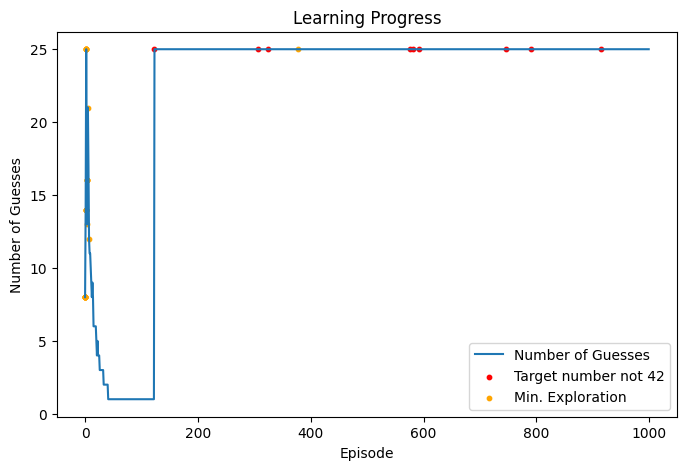

In [274]:
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 1
min_epsilon = 0.0001
decay_epsilon = 0.5

# Initialize Q-table
q_table = np.zeros((100, 100))

# Number of games during training
total_episodes = 1000

guess_counts = []
target_numbers = []
exploration_points = []

# Now you can run the training loop
for episode in range(total_episodes):
    target_number = initialize_game()
    done = False
    state = (1, 100)  # Initial state with the full range of possible numbers
    guess_count = 0
    
    while not done and guess_count < 25:  # Introduce a guess limit per episode
        # Choose an action (guess) using an epsilon-greedy policy
        if np.random.uniform(0, 1) < epsilon:
            # Exploration: random guess within the current state bounds
            guess = np.random.randint(state[0], state[1]+1)
            exploration_points.append((episode, guess_count))  # Record the exploration point
        else:
            # Exploitation: choose the best guess from Q-table within the current state bounds
            guess_range = q_table[state[0]-1:state[1]]
            best_guess = np.argmax(guess_range)
            guess = state[0] + best_guess
        
        feedback = get_feedback(guess, target_number)
        reward = calculate_reward(guess, target_number)
        done = feedback == 'correct'
        
        if feedback == 'higher':
            next_state = (guess + 1, state[1])
        elif feedback == 'lower':
            next_state = (state[0], guess - 1)
        else:
            next_state = state
        
        # Update Q-table
        action = guess - state[0]
        update_q_table(q_table, state, action, reward, next_state, alpha, gamma)
        
        state = next_state
        guess_count += 1

    guess_counts.append(guess_count)
    target_numbers.append(target_number)

    # Decrease epsilon over time
    epsilon = max(epsilon * decay_epsilon, min_epsilon)  # Ensure epsilon doesn't go below a certain threshold

# Plot the learning progress
plt.figure(figsize=(8, 5))  # Make the figure larger for better visibility
plt.plot(guess_counts, label='Number of Guesses')

# Mark the episodes with non-42 target numbers in red
non_42_scatter = plt.scatter([], [], color='red', s=10, label='Target number not 42')

# Mark the episodes where exploration occurred in green
exploration_scatter = plt.scatter([], [], color='orange', s=10, label='Min. Exploration')

# Actually plot the points where target number was not 42 and exploration happened
for i, target_number in enumerate(target_numbers):
    if target_number != 42:
        plt.scatter(i, guess_counts[i], color='red', s=10)

# Mark the episodes where exploration occurred in green
for point in exploration_points:
    episode, _ = point
    plt.scatter(episode, guess_counts[episode], color='orange', s=10)

plt.title('Learning Progress')
plt.xlabel('Episode')
plt.ylabel('Number of Guesses')
plt.legend()
plt.show()
